In [19]:
import os
import re
import operator
from typing import Dict, Any, List, TypedDict, Annotated, Sequence

# .env 파일 로드를 위한 라이브러리
from dotenv import load_dotenv

# LangChain 및 LangGraph 관련
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.documents import Document
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

# 데이터 시각화 관련
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# --- 환경 설정 ---
# .env 파일에서 API 키 로드
load_dotenv()
if "OPENAI_API_KEY" not in os.environ:
    print("경고: .env 파일에 OPENAI_API_KEY를 설정해주세요.")
else:
    print("✅ API 키 로드 완료.")

# 한글 폰트 설정 (그래프용)
try:
    font_path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = fm.FontProperties(fname=font_path).get_name()
    plt.rc('font', family=font_name)
    print(f"✅ 한글 폰트 '{font_name}' 설정 완료.")
except FileNotFoundError:
    print("⚠️ 경고: '맑은 고딕' 폰트를 찾을 수 없어 그래프의 한글이 깨질 수 있습니다.")
plt.rcParams['axes.unicode_minus'] = False

✅ API 키 로드 완료.
✅ 한글 폰트 'Malgun Gothic' 설정 완료.


In [21]:
import re
import os
from typing import Dict, Any, List

# 데이터 시각화 관련
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# LangChain 및 LangGraph 관련
from langchain_core.documents import Document
from langchain_core.tools import tool
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

# --- 함수 및 도구 정의 ---

def load_menu_from_file(file_path: str) -> list[dict]:
    """사용자님의 txt 파일 형식에 맞춰 메뉴 데이터를 읽어와 딕셔너리 리스트로 반환합니다."""
    if not os.path.exists(file_path):
        print(f"❌ 오류: 데이터 파일 '{file_path}'을(를) 찾을 수 없습니다.")
        return []
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    menu_items_raw = re.split(r'\n\s*\n', content.strip())
    menu_data_list = []
    for item_raw in menu_items_raw:
        lines = item_raw.strip().split('\n')
        name_match = re.match(r'\d+\.\s*(.*)', lines.pop(0))
        if not name_match: continue
        menu_item: dict[str, any] = {'menu_name': name_match.group(1).strip()}
        for line in lines:
            if line.strip().startswith('•'):
                parts = line.strip().lstrip('• ').split(':', 1)
                if len(parts) == 2:
                    key, value = parts[0].strip(), parts[1].strip()
                    if key == '가격': menu_item['price'] = value
                    elif key == '설명': menu_item['description'] = value
        menu_data_list.append(menu_item)
    return menu_data_list

@tool
def search_cafe_menu(query: str) -> str:
    """카페 메뉴의 가격, 설명 등 텍스트 정보에 대한 질문에 답변할 때 사용합니다."""
    if not menu_data: return "메뉴 데이터가 로드되지 않았습니다."
    documents = [Document(page_content=f"메뉴:{item.get('menu_name', '')}, 가격:{item.get('price', '')}, 설명:{item.get('description', '')}") for item in menu_data]
    db = FAISS.from_documents(documents, OpenAIEmbeddings(model="text-embedding-3-small"))
    docs = db.similarity_search(query, k=2)
    return "\n\n".join([doc.page_content for doc in docs]) if docs else "관련 정보를 찾지 못했습니다."

@tool
def create_price_comparison_graph(menu_names: list[str]) -> str:
    """여러 메뉴의 가격을 막대 그래프로 비교하여 실행 결과에 바로 표시합니다."""
    if not menu_data: return "메뉴 데이터가 로드되지 않았습니다."
    prices, valid_names = [], []
    for name in menu_names:
        for item in menu_data:
            if name.lower() in item.get('menu_name', '').lower():
                prices.append(int(re.sub(r'[^\d]', '', item.get('price', '0'))))
                valid_names.append(item.get('menu_name', ''))
                break
    if not prices: return "그래프를 생성할 메뉴 정보를 찾지 못했습니다."

    plt.figure(figsize=(10, 6))
    bars = plt.bar(valid_names, prices, color='skyblue')
    plt.ylabel('가격 (원)')
    plt.title('메뉴별 가격 비교')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:,}원', va='bottom', ha='center')
    
    plt.show() # 그래프를 셀 결과에 바로 표시
    return "메뉴 가격 비교 그래프를 표시했습니다."

print("✅ 데이터 로더 및 2가지 도구(정보 검색, 그래프 표시) 정의 완료.")

✅ 데이터 로더 및 2가지 도구(정보 검색, 그래프 표시) 정의 완료.


In [22]:
# 데이터 파일 경로 설정 및 로드
data_file_path = '../data/cafe_menu_data.txt'
menu_data = load_menu_from_file(data_file_path)

if menu_data:
    print(f"✅ 총 {len(menu_data)}개의 메뉴 데이터를 파일에서 로드했습니다.")
    # 에이전트가 사용할 도구 목록
    tools = [search_cafe_menu, create_price_comparison_graph]
    
    # 모델에 도구 바인딩
    model = ChatOpenAI(temperature=0).bind_tools(tools)
    
    # 상태 정의
    class AgentState(TypedDict):
        messages: Annotated[Sequence[BaseMessage], operator.add]

    # 노드 정의
    agent = lambda state: {"messages": [model.invoke(state["messages"])]}
    tool_node = ToolNode(tools)
    should_continue = lambda state: "action" if state["messages"][-1].tool_calls else "end"
    
    print("✅ 에이전트 구성 요소 준비 완료.")
else:
    print("❌ 메뉴 데이터 로드에 실패하여 에이전트를 구성할 수 없습니다.")

✅ 총 10개의 메뉴 데이터를 파일에서 로드했습니다.
✅ 에이전트 구성 요소 준비 완료.


In [23]:
if menu_data:
    # 워크플로우 생성
    workflow = StateGraph(AgentState)
    workflow.add_node("agent", agent)
    workflow.add_node("action", tool_node)
    
    # 엣지 및 진입점 설정
    workflow.set_entry_point("agent")
    workflow.add_conditional_edges("agent", should_continue, {"action": "action", "end": END})
    workflow.add_edge("action", "agent")
    
    # 컴파일
    app = workflow.compile()
    print("✅ ReAct 에이전트 및 워크플로우 구성 완료.")
else:
    print("❌ 워크플로우를 구성할 수 없습니다.")

✅ ReAct 에이전트 및 워크플로우 구성 완료.



질문: 티라미수 얼마야?
응답: 티라미수의 가격은 ₩7,500 입니다. 이탈리아 전통 디저트로 마스카포네 치즈와 에스프레소에 적신 레이디핑거를 층층이 쌓아 만들었습니다. 부드럽고 달콤한 맛이 특징이며, 코코아 파우더로 마무리하여 깊은 풍미를 자랍니다.

질문: 아메리카노랑 카페라떼, 티라미수 가격을 그래프로 비교해줘


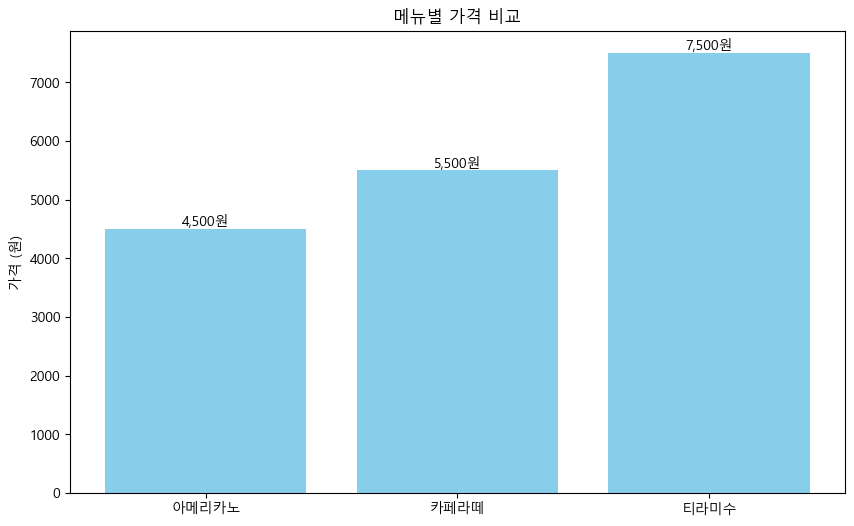

응답: 여기 아메리카노, 카페라떼, 티라미수의 가격 비교 그래프가 있습니다. 아메리카노가 4,500원, 카페라떼가 5,500원, 티라미수가 6,000원으로 나타납니다.


In [24]:
def run_agent(question: str):
    """질문을 입력받아 에이전트를 실행하고 결과를 출력하는 함수"""
    if not menu_data:
        print("❌ 에이전트를 실행할 수 없습니다. 메뉴 데이터를 먼저 로드해주세요.")
        return

    print("\n" + "="*50)
    print(f"질문: {question}")
    inputs = {"messages": [HumanMessage(content=question)]}
    response = app.invoke(inputs)
    final_answer = response['messages'][-1].content
    print(f"응답: {final_answer}")
    if ".png" in final_answer:
        print("==> 현재 폴더에 이미지 파일이 생성되었는지 확인해보세요!")
    print("="*50)

# 테스트 1: 텍스트 정보 검색
run_agent("티라미수 얼마야?")

# 테스트 2: 데이터 시각화 그래프 생성
run_agent("아메리카노랑 카페라떼, 티라미수 가격을 그래프로 비교해줘")